Stewart Sidauruk - 220711816 - TensorFlow - Buah Berry - VGG-16

In [49]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.callbacks import EarlyStopping

In [50]:
count = 0
dirs = os.listdir(r'C:\Users\stewa\Downloads\UAS\train_data')
for dir in dirs:
    files = list(os.listdir(r'C:\Users\stewa\Downloads\UAS\train_data/'+dir))
    print(dir + ' Folder has ' + str(len(files)) + ' Images')
    count = count + len(files)
print('Images Folder has ' + str(count) + ' Images')

BlackBerry Folder has 100 Images
Blueberry Folder has 100 Images
strawberry Folder has 100 Images
Images Folder has 300 Images


In [51]:
import os
from PIL import Image

base_dir = r'C:\Users\stewa\Downloads\UAS\train_data'

for root, _, files in os.walk(base_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)
            img.verify()
        except Exception as e:
            print(f"Corrupted or unsupported file: {file_path} - {e}")


In [52]:
# Parameter
base_dir = r'C:\Users\stewa\Downloads\UAS\train_data'
img_size = (224, 224)
batch = 32
validation_split = 0.1
test_split = 0.1

In [53]:
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123,
    image_size=img_size,
    batch_size=batch,
)


Found 300 files belonging to 3 classes.


In [54]:
class_names = dataset.class_names
print("Class Names:", class_names)

Class Names: ['BlackBerry', 'Blueberry', 'strawberry']


In [55]:
total_count = len(dataset)
val_count = int(total_count * validation_split)
tes_count = int(total_count * test_split)
train_count = total_count - val_count - tes_count

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)
print("Test Images:", tes_count)

Total Images: 10
Train Images: 8
Validation Images: 1
Test Images: 1


In [56]:
train_ds = dataset.take(train_count)
remaining = dataset.skip(train_count)
val_ds = remaining.take(val_count)
tes_ds = remaining.skip(tes_count)

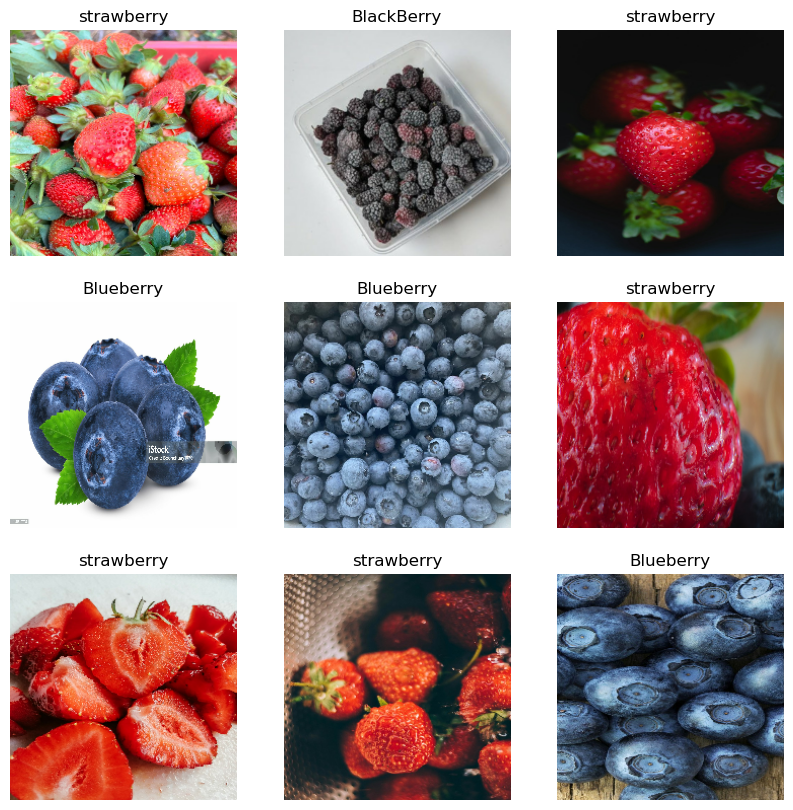

In [57]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [58]:
import numpy as np

for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)

(32, 224, 224, 3)


In [59]:
AUTOTUNE = tf.data.AUTOTUNE

In [60]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [61]:
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [62]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_size[0], img_size[1], 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


c:\Users\stewa\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


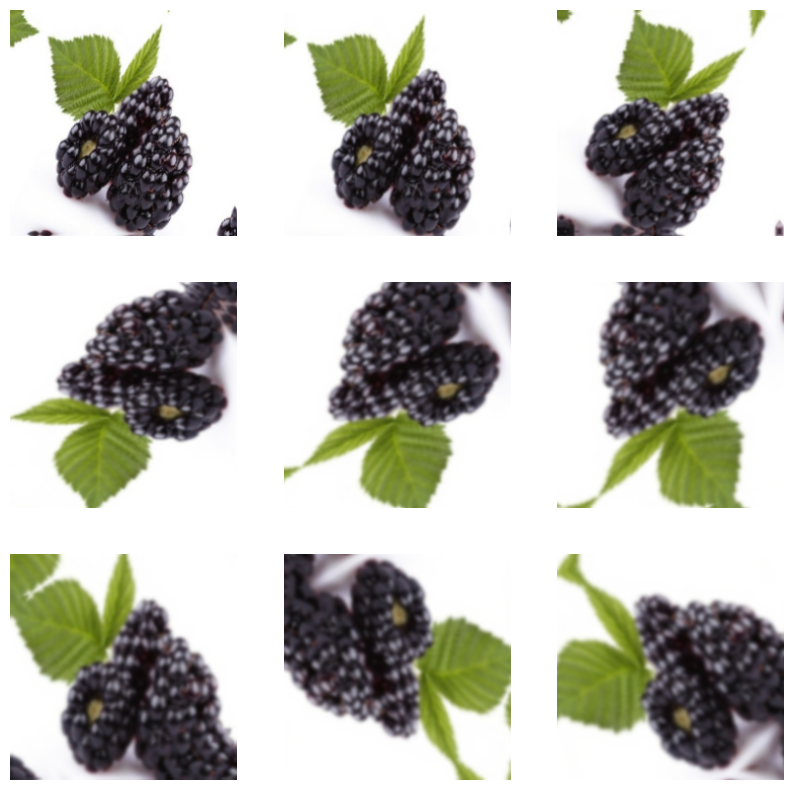

In [63]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [64]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import layers

base_model = VGG16(include_top=False, input_shape=(img_size[0], img_size[1], 3))

base_model.trainable = True
fine_tune_at = len(base_model.layers) // 2
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False 

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [65]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [66]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 13,635,331 (52.01 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

In [67]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    mode='max',
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stopping]
)



Epoch 1/30


8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.5163 - loss: 1.0746 - val_accuracy: 0.8125 - val_loss: 0.5692
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.8526 - loss: 0.4265 - val_accuracy: 0.9688 - val_loss: 0.0848
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.9518 - loss: 0.1574 - val_accuracy: 1.0000 - val_loss: 0.0320
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.9752 - loss: 0.0795 - val_accuracy: 1.0000 - val_loss: 0.0136
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.9840 - loss: 0.0499 - val_accuracy: 1.0000 - val_loss: 0.0098
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.9872 - loss: 0.0412 - val_accuracy: 1.0000 - val_loss: 0.0098


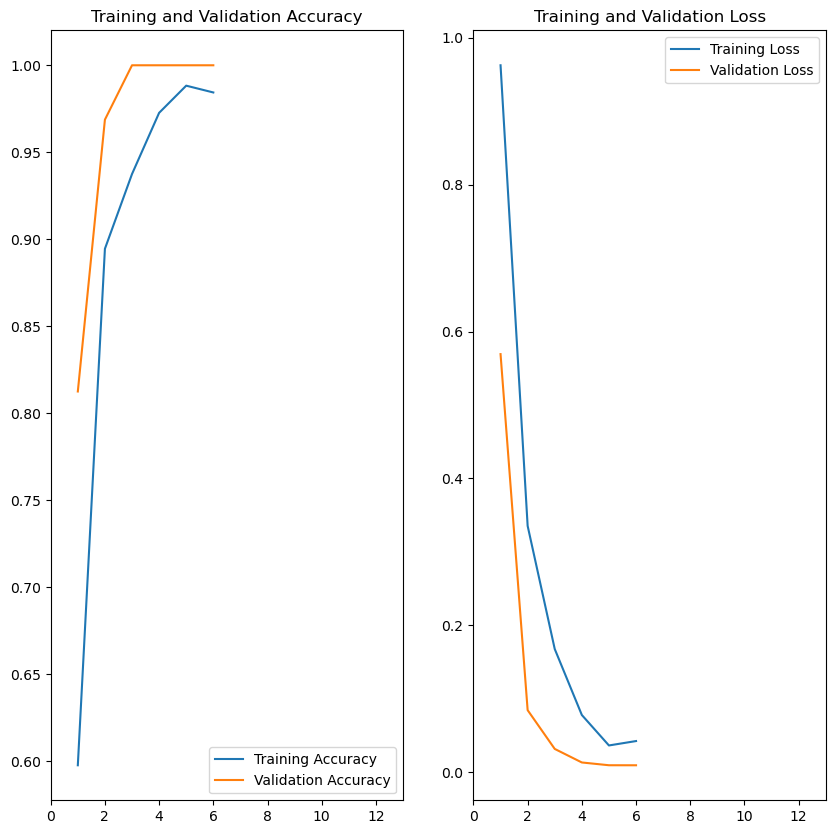

In [68]:
ephocs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlim(0, 13)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(0, 13)
plt.title('Training and Validation Loss')
plt.show()

In [69]:
#menyimpan model yang telah dilatih
model.save('BestModel_VGG-16_Tensorflow.h5')

In [70]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

model = load_model(r'C:\Users\stewa\Downloads\TUBES_ML\BestModel_VGG-16_Tensorflow.h5')
class_names = ['BlackBerry', 'Blueberry', 'strawberry']

def classify_images(image_path, save_path='predicted_image.jpg'):
    try:

        input_image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)

        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

result = classify_images(r'C:\Users\stewa\Downloads\UAS\test_data\blackberry\Home.jpg', save_path='blackberry.jpg')
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Prediksi: BlackBerry
Confidence: 57.51%
Prediksi: BlackBerry dengan confidence 57.51%. Gambar asli disimpan di blackberry.jpg.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


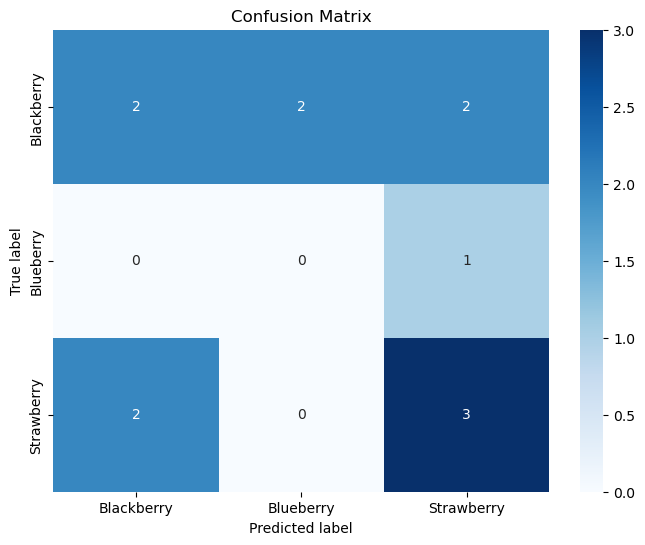

Confusion Matrix:
 [[2 2 2]
 [0 0 1]
 [2 0 3]]
Akurasi: 0.4166666666666667
Presisi: [0.5 0.  0.5]
Recall: [0.33333333 0.         0.6       ]
F1 Score: [0.4               nan 0.54545455]


In [71]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

vgg16_model = load_model(r'C:\Users\stewa\Downloads\TUBES_ML\BestModel_VGG-16_Tensorflow.h5')  # Gunakan path model Anda

# Memuat data uji yang sebenarnya
test_data = tes_ds

# Melakukan prediksi menggunakan model
y_pred = vgg16_model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)  # Konversi ke kelas prediksi

# Ekstrak label sebenarnya dari test_data dan konversi ke bentuk indeks kelas
# Extract actual labels from test_data
true_labels = []  # Store true labels as integers
for _, labels in test_data:
    true_labels.extend(labels.numpy())  # Directly convert TensorFlow tensor to NumPy array and extend the list

true_labels = tf.convert_to_tensor(true_labels)  # Convert the list to a TensorFlow tensor for calculations
  # Mengonversi list ke tensor untuk perhitungan

# Membuat confusion matrix untuk evaluasi
conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

# Menghitung akurasi berdasarkan confusion matrix
accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

# Menghitung presisi dan recall dari confusion matrix
precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

# Menghitung F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))  # Mengatur ukuran gambar
sns.heatmap(
    conf_mat.numpy(),
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=["Blackberry", "Blueberry", "Strawberry"],  # Label prediksi
    yticklabels=["Blackberry", "Blueberry", "Strawberry"],  # Label asli
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Menampilkan hasil evaluasi
print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())
